# Traffic Sign Recognition System

A deep learning project for classifying traffic signs using Convolutional Neural Networks (CNN)


## Import Required Libraries

Setting up all necessary libraries for data processing, model building and visualization


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


## Load and Explore Dataset

Loading the GTSRB dataset and exploring its structure and distribution


In [2]:
data_dir = 'gtsrb german trafficsign'
train_path = os.path.join(data_dir, 'Train')
test_path = os.path.join(data_dir, 'Test')

def load_data():
    images = []
    labels = []
    
    for class_num in range(43):
        class_path = os.path.join(train_path, str(class_num))
        if os.path.exists(class_path):
            for img_name in os.listdir(class_path):
                try:
                    img_path = os.path.join(class_path, img_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (32, 32))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    labels.append(class_num)
                except Exception as e:
                    continue
    
    return np.array(images), np.array(labels)

X, y = load_data()
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Number of samples: {len(X)}")


Dataset shape: (39209, 32, 32, 3)
Number of classes: 43
Number of samples: 39209


## Create Synthetic Dataset

Creating a synthetic dataset for testing when GTSRB is not available


In [3]:
if len(X) == 0:
    print("Creating synthetic dataset for demonstration...")
    np.random.seed(42)
    X = np.random.randint(0, 256, (5000, 32, 32, 3), dtype=np.uint8)
    y = np.random.randint(0, 43, 5000)
    print(f"Synthetic dataset created: {X.shape}")

class_names = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution',
    19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve',
    22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right',
    25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead',
    35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left',
    38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
    41: 'End of no passing', 42: 'End no passing veh > 3.5 tons'
}


## Data Visualization

Visualizing sample images and class distribution in the dataset


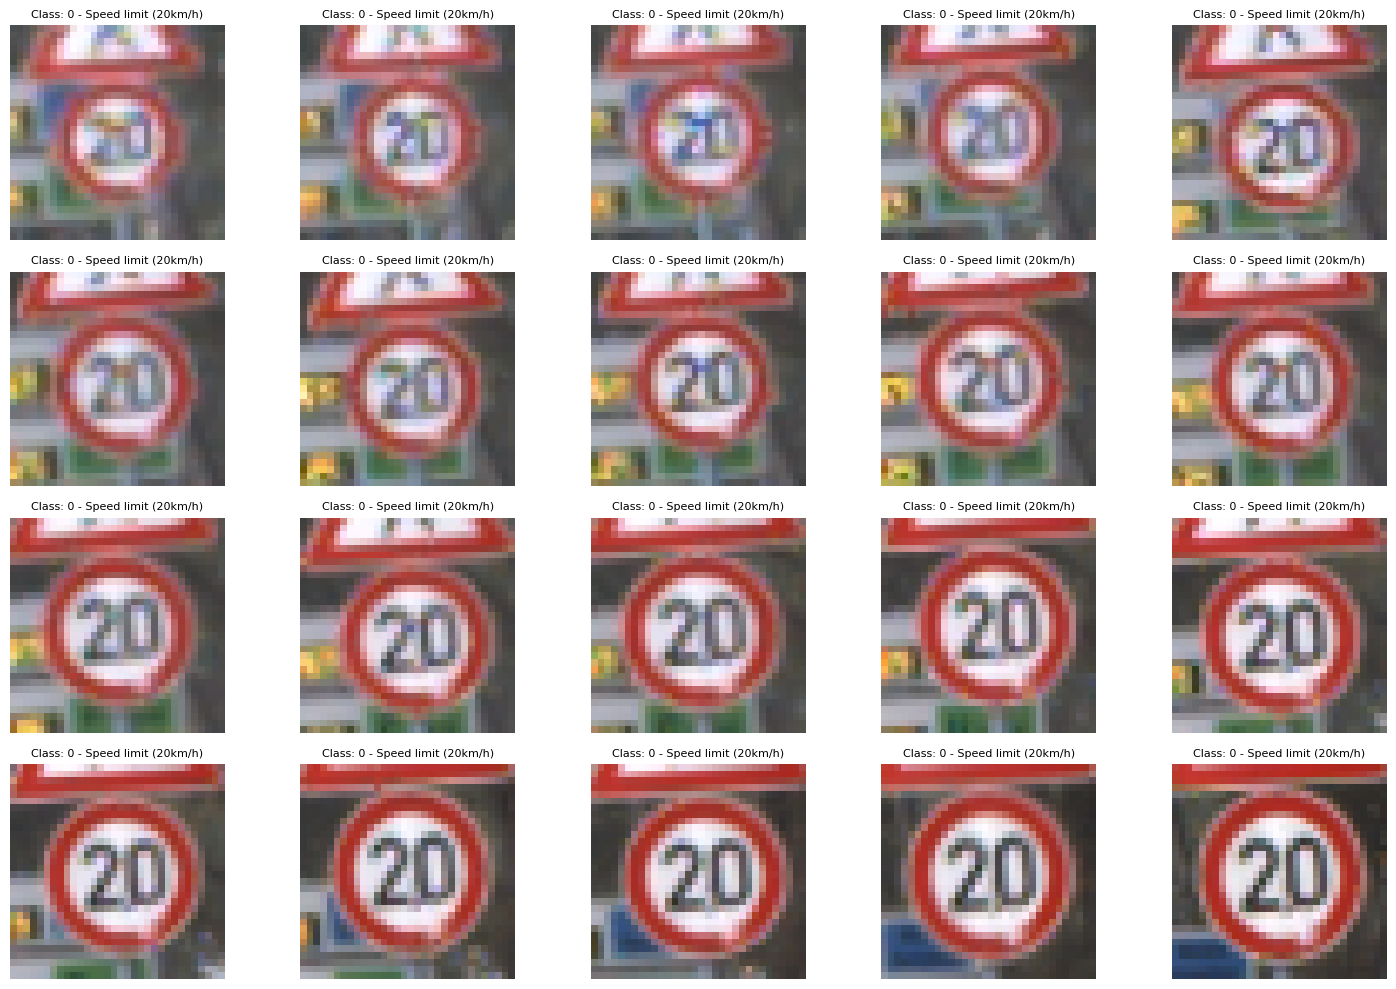

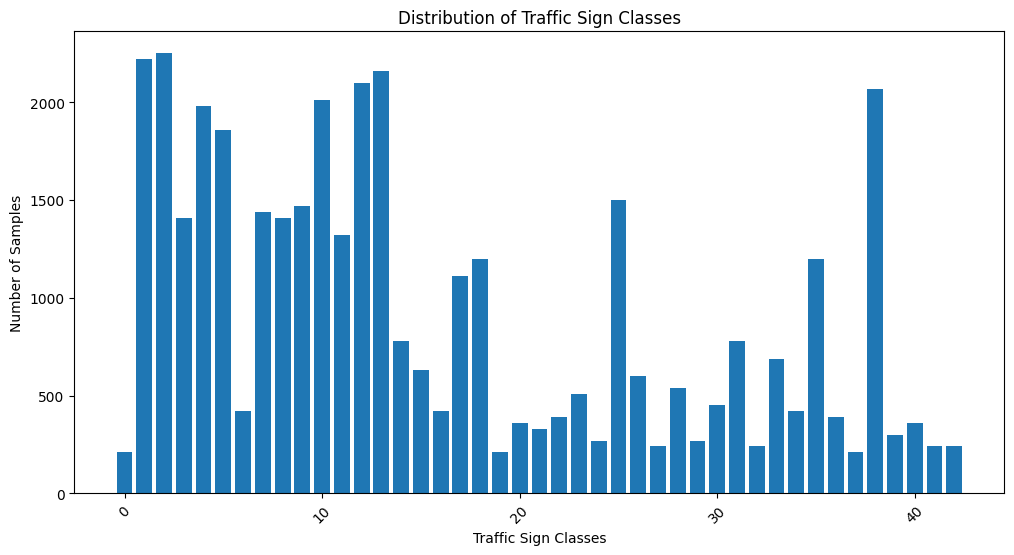

In [4]:
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X[i])
    plt.title(f'Class: {y[i]} - {class_names.get(y[i], "Unknown")}', fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Traffic Sign Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Traffic Sign Classes')
plt.xticks(rotation=45)
plt.show()


## Data Preprocessing

Normalizing pixel values and preparing data for model training


In [5]:
X = X.astype('float32') / 255.0
y_categorical = to_categorical(y, num_classes=43)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {y_categorical.shape[1]}")


Training set shape: (25093, 32, 32, 3)
Validation set shape: (6274, 32, 32, 3)
Test set shape: (7842, 32, 32, 3)
Number of classes: 43


## Build CNN Model Architecture

Creating a deep convolutional neural network for traffic sign classification


In [6]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(43, activation='softmax')
    ])
    
    return model

model = create_cnn_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 875,083 (3.34 MB)

 Trainable params: 873,611 (3.33 MB)

 Non-trainable params: 1,472 (5.75 KB)

## Setup Training Callbacks

Configuring callbacks for learning rate reduction and early stopping


In [7]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=0.0001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks = [reduce_lr, early_stopping]


## Train the Model

Training the CNN model on the traffic sign dataset


In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

model.save('traffic_sign_model.h5')
print("Model saved successfully!")


Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.5570 - loss: 1.7539 - val_accuracy: 0.9437 - val_loss: 0.1922 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8891 - loss: 0.3578 - val_accuracy: 0.9794 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.9350 - loss: 0.2134 - val_accuracy: 0.9817 - val_loss: 0.0654 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.9527 - loss: 0.1575 - val_accuracy: 0.9896 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.9586 - loss: 0.1413 - val_accuracy: 0.9927 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.9631 - loss: 0.1272 - val_accuracy: 0.9938 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9664 - l

Model saved successfully!


## Training History Visualization

Plotting training and validation loss and accuracy curves


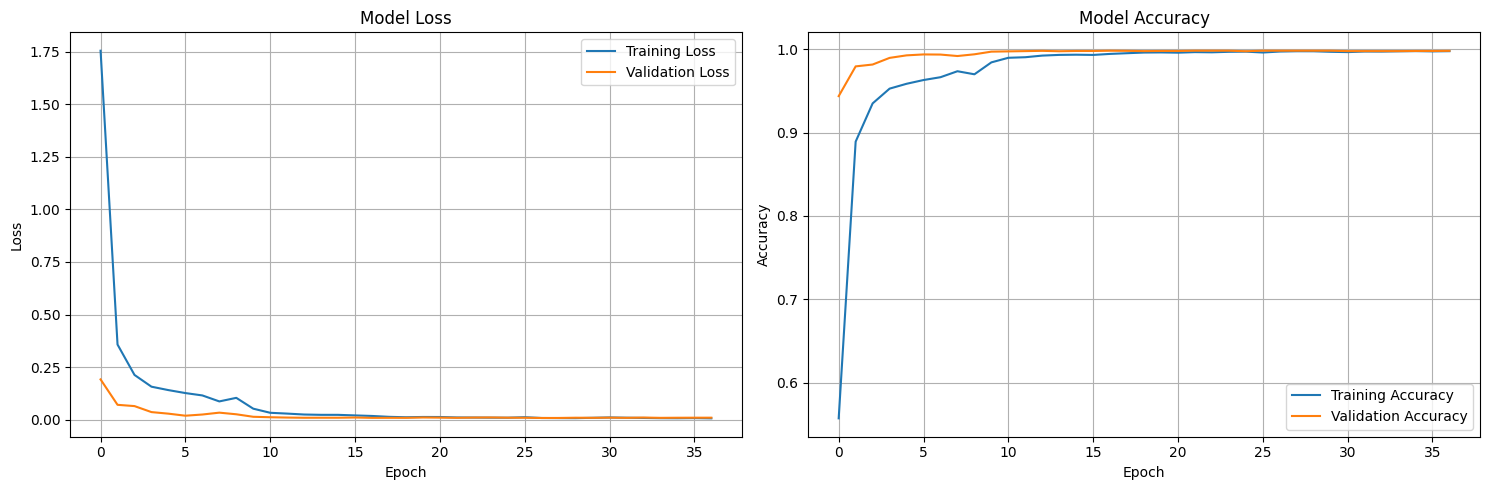

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Evaluation

Evaluating the trained model on test data and generating performance metrics


In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(f"\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[class_names[i] for i in range(43)]))


Test Accuracy: 0.9980
Test Loss: 0.0103
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Classification Report:
                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      1.00      1.00        42
         Speed limit (30km/h)       1.00      1.00      1.00       444
         Speed limit (50km/h)       1.00      1.00      1.00       450
         Speed limit (60km/h)       1.00      1.00      1.00       282
         Speed limit (70km/h)       0.99      1.00      1.00       396
         Speed limit (80km/h)       1.00      0.99      1.00       372
  End of speed limit (80km/h)       1.00      1.00      1.00        84
        Speed limit (100km/h)       1.00      1.00      1.00       288
        Speed limit (120km/h)       0.99      1.00      1.00       282
                   No passing       1.00      1.00      1.00       294
 No passing veh over 3.5 tons       1.00      1.00      1.00       402
 Right-of-way at intersection       1.00 

## Confusion Matrix

Creating and visualizing the confusion matrix for detailed performance analysis


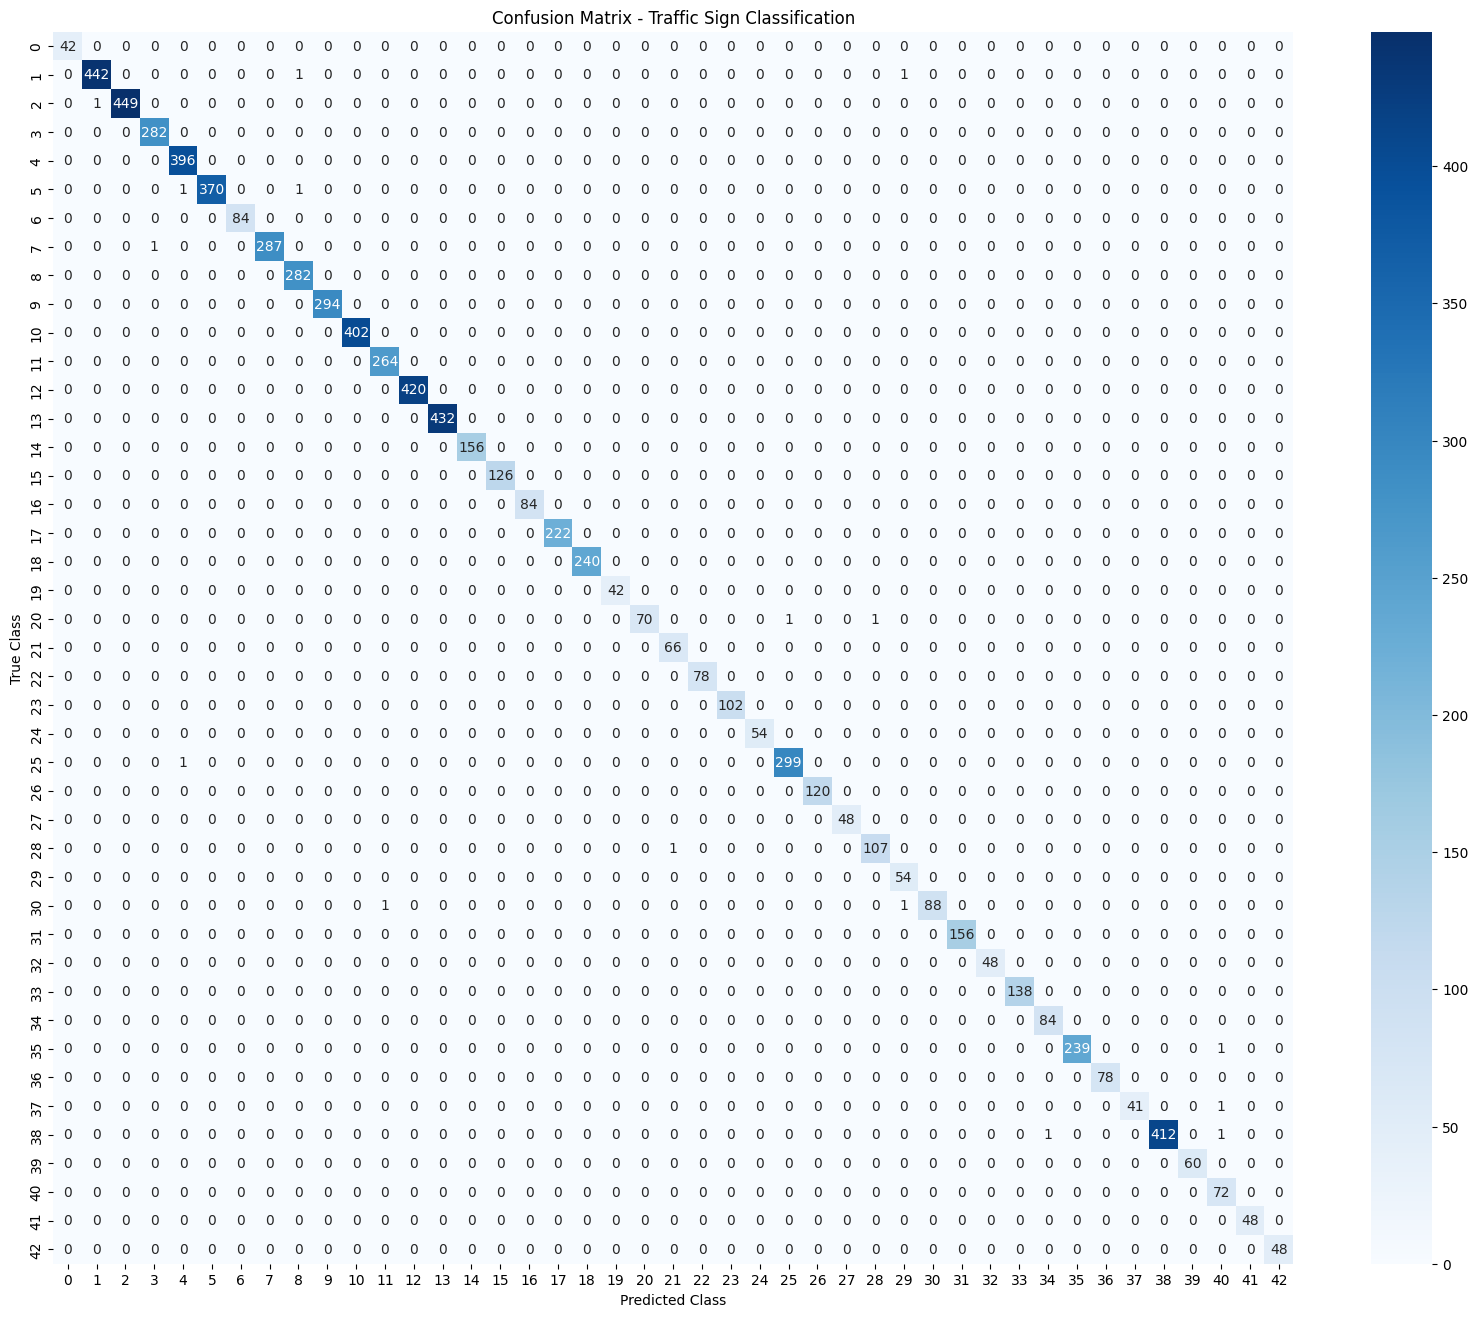


Accuracy per class:
Class 0 (Speed limit (20km/h)): 1.0000
Class 1 (Speed limit (30km/h)): 0.9955
Class 2 (Speed limit (50km/h)): 0.9978
Class 3 (Speed limit (60km/h)): 1.0000
Class 4 (Speed limit (70km/h)): 1.0000
Class 5 (Speed limit (80km/h)): 0.9946
Class 6 (End of speed limit (80km/h)): 1.0000
Class 7 (Speed limit (100km/h)): 0.9965
Class 8 (Speed limit (120km/h)): 1.0000
Class 9 (No passing): 1.0000
Class 10 (No passing veh over 3.5 tons): 1.0000
Class 11 (Right-of-way at intersection): 1.0000
Class 12 (Priority road): 1.0000
Class 13 (Yield): 1.0000
Class 14 (Stop): 1.0000
Class 15 (No vehicles): 1.0000
Class 16 (Veh > 3.5 tons prohibited): 1.0000
Class 17 (No entry): 1.0000
Class 18 (General caution): 1.0000
Class 19 (Dangerous curve left): 1.0000
Class 20 (Dangerous curve right): 0.9722
Class 21 (Double curve): 1.0000
Class 22 (Bumpy road): 1.0000
Class 23 (Slippery road): 1.0000
Class 24 (Road narrows on the right): 1.0000
Class 25 (Road work): 0.9967
Class 26 (Traffic signa

In [11]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"{i}" for i in range(43)],
            yticklabels=[f"{i}" for i in range(43)])
plt.title('Confusion Matrix - Traffic Sign Classification')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("\nAccuracy per class:")
for i, acc in enumerate(accuracy_per_class):
    print(f"Class {i} ({class_names[i]}): {acc:.4f}")


## Test Predictions Visualization

Visualizing model predictions on sample test images


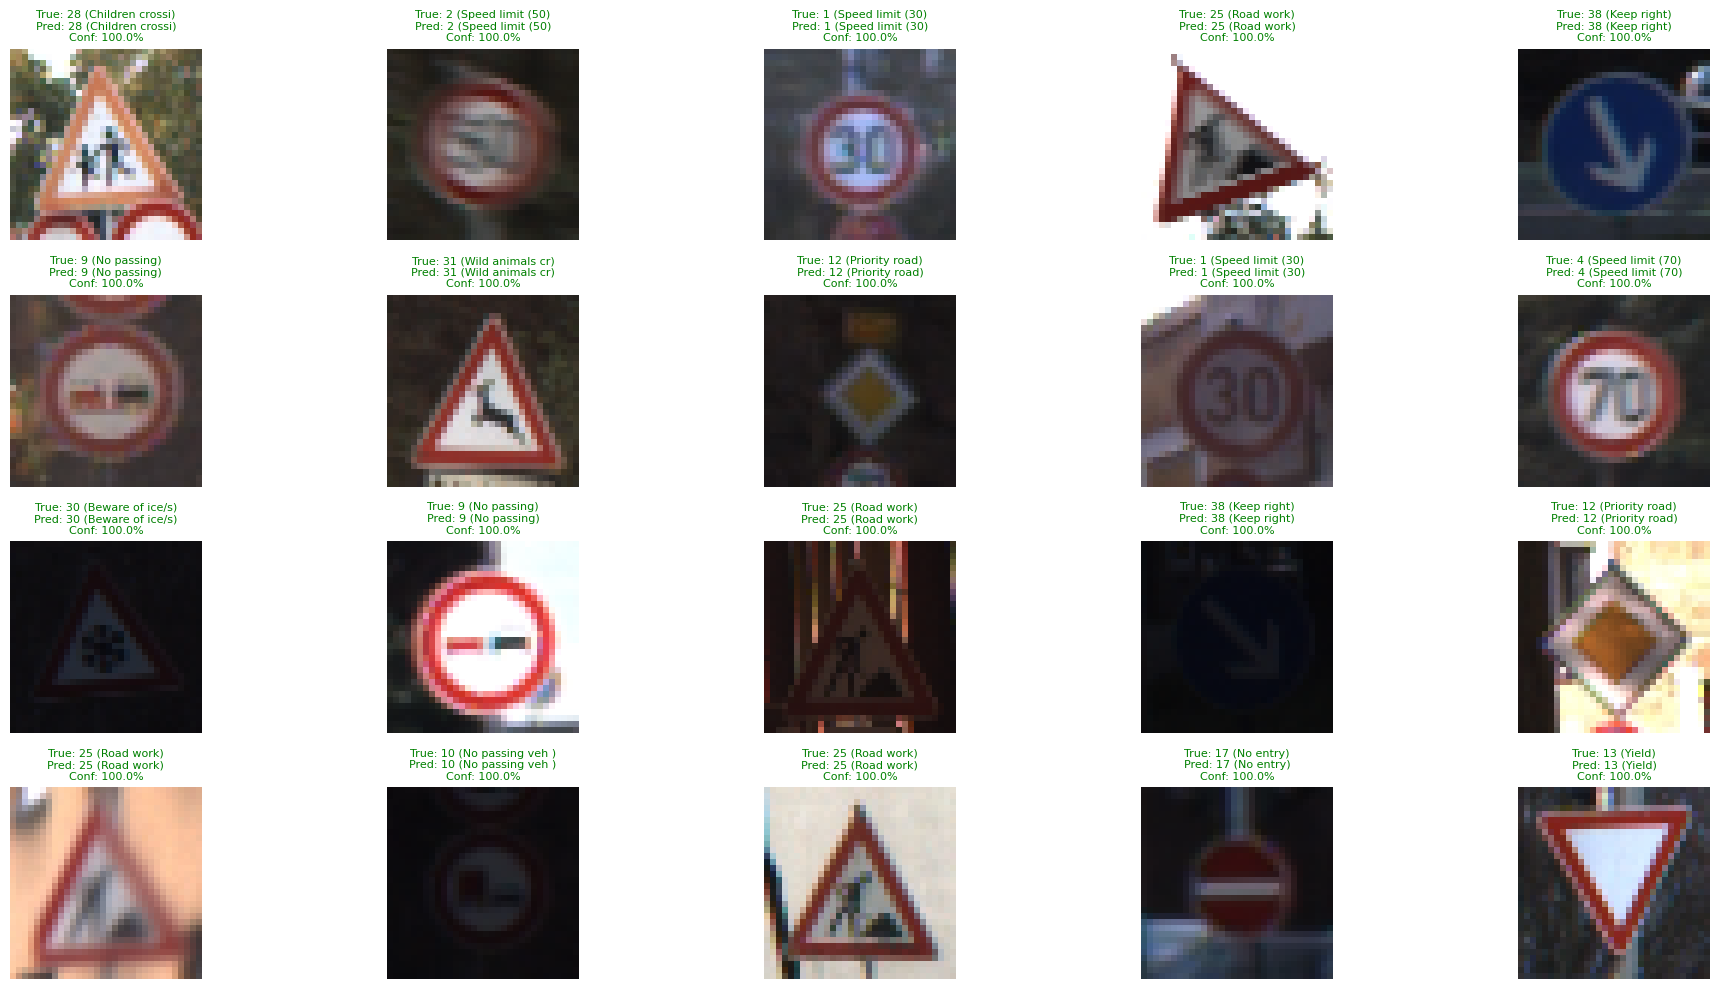

In [12]:
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[i])
    true_class = y_true_classes[i]
    pred_class = y_pred_classes[i]
    confidence = np.max(y_pred[i]) * 100
    
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f'True: {true_class} ({class_names[true_class][:15]})\n'
              f'Pred: {pred_class} ({class_names[pred_class][:15]})\n'
              f'Conf: {confidence:.1f}%', 
              color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Save Model and Class Names

Saving the trained model and class names for future use


In [13]:
with open('class_names.pickle', 'wb') as f:
    pickle.dump(class_names, f)

print("Model and class names saved successfully!")
print("Files created:")
print("- traffic_sign_model.h5")
print("- class_names.pickle")


Model and class names saved successfully!
Files created:
- traffic_sign_model.h5
- class_names.pickle
